In [109]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import umap.umap_ as umap
import plotly.express as px
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

In [110]:
d = pd.read_csv(r"neuralData_cross_validation.csv")

In [111]:
d

,x,lap,c1,c2,c3,c4,c5,c6,c7,c8,...,c167,c168,c169,c170,c171,c172,c173,c174,c175,c176
0,5.505403,1,0.0,0.000000,0.0,0.000000,0,0.0,0.108977,0.000000,...,0.0,0.054489,0.0,0.0,0.0,5.098882,0.000000,0.000000,0.0,0.000000
1,5.505403,1,0.0,0.000000,0.0,0.000000,0,0.0,0.402620,0.000000,...,0.0,0.402620,0.0,0.0,0.0,4.353179,0.000000,0.000000,0.0,0.000000
2,4.392248,1,0.0,0.000000,0.0,0.000000,0,0.0,0.244201,0.000000,...,0.0,0.244201,0.0,0.0,0.0,3.516645,0.000000,0.000000,0.0,0.000000
3,4.392248,1,0.0,0.000000,0.0,0.000000,0,0.0,0.054489,0.000000,...,0.0,0.054489,0.0,0.0,0.0,3.542891,0.000000,0.000000,0.0,0.000000
4,4.392248,1,0.0,0.000000,0.0,0.000000,0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,3.641774,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,194.090625,16,0.0,0.244201,0.0,0.488403,0,0.0,0.402620,1.452061,...,0.0,0.244201,0.0,0.0,0.0,0.976805,0.244201,0.244201,0.0,0.054489
1847,194.090625,16,0.0,0.402620,0.0,0.805240,0,0.0,0.244201,1.135224,...,0.0,0.402620,0.0,0.0,0.0,1.262349,0.402620,0.402620,0.0,0.244201
1848,194.090625,16,0.0,0.244201,0.0,0.488403,0,0.0,0.054489,0.407667,...,0.0,0.244201,0.0,0.0,0.0,0.732604,0.244201,0.244201,0.0,0.402620
1849,193.828848,16,0.0,0.054489,0.0,0.108977,0,0.0,0.000000,0.054489,...,0.0,0.054489,0.0,0.0,0.0,0.163466,0.054489,0.054489,0.0,0.244201


In [112]:
data = d.dropna()
allGoodCol = data.columns
allGoodCol = list(allGoodCol)
allGoodCol = allGoodCol[2::]
data_size = data.shape[0]

In [113]:
# Now we select which lines of df are train / test
# Ten-fold cross validation

all_index = np.arange(data_size)
num_folds = 10
fold_size = data_size // num_folds
test_list = []
train_list = []

for i in range(num_folds):
    test = np.random.choice(data_size, size=fold_size, replace=False)
    test_list.append(test)
    train = np.setdiff1d(all_index, test)
    train_list.append(train)

## UMAP lap decoding

In [114]:
reducer = umap.UMAP(n_neighbors = 20, 
                    metric = 'cosine', 
                    output_metric = 'euclidean',
                    learning_rate = 1.0, 
                    init = 'spectral', 
                    min_dist = 0.1, 
                    spread = 1.0, 
                    repulsion_strength = 1.0,
                    negative_sample_rate = 5,
                    target_metric = 'categorical', 
                    dens_lambda = 2.0, 
                    dens_frac = 0.3,
                    dens_var_shift=0.1,
                    n_components = 3)

parsedData = data[allGoodCol].values

embedding = reducer.fit_transform(parsedData)
embedding.shape

(1851, 3)

In [115]:
df = pd.DataFrame(embedding, columns=['x1', 'x2', 'x3'])
df["x"] = data.x
df["lap"] = data.lap
# df["speed"] = data.speed

In [116]:
fig = px.scatter_3d(df, x='x1', y='x2', z='x3',
              color='lap', opacity=0.9)

fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [117]:
score = []

# We perform the decoding
for fold in range(num_folds):
    print(f"Fold {fold}")

    test = test_list[fold]
    train = train_list[fold]

    train_data = data.iloc[train]
    test_data = data.iloc[test]

    train_laps = train_data.lap
    test_laps = test_data.lap

    # We train the UMAP

    reducer = umap.UMAP(n_neighbors = 20, 
                    metric = 'cosine', 
                    output_metric = 'euclidean',
                    learning_rate = 1.0, 
                    init = 'spectral', 
                    min_dist = 0.1, 
                    spread = 1.0, 
                    repulsion_strength = 1.0,
                    negative_sample_rate = 5,
                    target_metric = 'categorical', 
                    dens_lambda = 2.0, 
                    dens_frac = 0.3,
                    dens_var_shift=0.1,
                    n_components = 3)

    parsedData = train_data[allGoodCol].values
    embedding_train = reducer.fit_transform(parsedData, y = train_laps)

    # We project the test points

    parsedTestData = test_data[allGoodCol].values
    embedding_test = reducer.transform(parsedTestData)

    # We train a KNN decoder with 1 neighbor
    neigh = KNeighborsClassifier(n_neighbors = 1)
    neigh.fit(embedding_train, train_laps)

    # We predict the lap number of test points
    predicted_laps = neigh.predict(embedding_test)
    mean_diff = np.mean(np.abs(predicted_laps - test_laps))
    score.append(mean_diff)




Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


### Firing rate lap decoding

<Axes: xlabel='lap'>

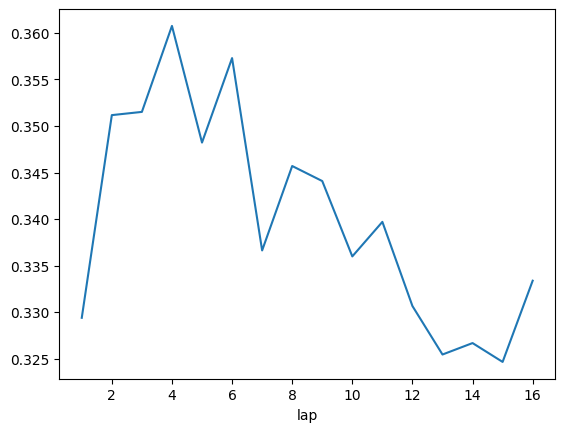

In [118]:
# Plot the mean firing rate across laps

mean_per_lap = data.groupby("lap").mean()
mean_all_cells = mean_per_lap.iloc[:, 1:].mean(axis=1)
mean_all_cells.plot()

In [119]:
# Create the meaned data for train / test
meaned_data = data[allGoodCol].mean(axis=1)

score_FR = []

# We perform the decoding
for fold in range(num_folds):
    print(f"Fold {fold}")

    test = test_list[fold]
    train = train_list[fold]

    train_data = data.iloc[train]
    test_data = data.iloc[test]

    train_laps = train_data.lap
    test_laps = test_data.lap

    # Create the meaned data for train / test
    meaned_train = train_data[allGoodCol].mean(axis=1)
    meaned_test = test_data[allGoodCol].mean(axis=1)

    # We train a KNN decoder with 1 neighbor
    neigh = KNeighborsClassifier(n_neighbors = 1)
    neigh.fit(meaned_train.values.reshape(-1, 1), train_laps)

    # We predict the lap number of test points
    predicted_laps = neigh.predict(meaned_test.values.reshape(-1, 1))
    mean_diff = np.mean(np.abs(predicted_laps - test_laps))
    score_FR.append(mean_diff)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


In [120]:
import seaborn as sns
plot_data = pd.DataFrame({'Value': np.concatenate([score, score_FR]),
                     'Category': ['List1']*len(score) + ['List2']*len(score_FR)})

sns.swarmplot(x='Category', y='Value', data=data)

ValueError: Could not interpret value `Category` for `x`. An entry with this name does not appear in `data`.